## Calculate modes and extinction of silicon disk

These calculations are performed with relatively high accuracy settings, so they will take several hours to run

In [1]:
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt

import os.path as osp
import numpy as np
import scipy.linalg as la
import dill as pickle

import openmodes
from openmodes.material import IsotropicMaterial
from openmodes.operator.penetrable import PMCHWTOperator, CTFOperator
from openmodes.sources import PlaneWaveSource
from openmodes.basis import DivRwgBasis, LoopStarBasis
from openmodes.constants import eta_0, c
from openmodes.integration import RectangularContour, EllipticalContour, ExternalModeContour, DunavantRule, GaussLegendreRule
from openmodes.model import ModelSplit, ModelMutualWeight

print("This notebook was generated using OpenModes version {}".format(openmodes.__version__))

This notebook was generated using OpenModes version 1.2.0


## Turning on logging
Uncomment the lines below to turn on additional logging information

In [2]:
# import logging
# logging.getLogger().setLevel(logging.INFO)

## Setup simulation

The cells below set up the simulation object, and specify the geometric and material parameters of the disk

In [3]:
sim = openmodes.Simulation(operator_class=CTFOperator, notebook=True)

parameters={'radius':242e-9, 'height':220e-9, 'mesh_tol':50e-9, 'rounding':50e-9}

In [4]:
def eps_si_green(s):
    """Permittivity of Silicon, fitting to Green and Keevers 1995
    
    Fitted with 4 poles, plus their conjugates and a constant background term in the range 300-1200THz (1μm-0.25μm)
    """
    s = np.atleast_1d(s)
    omega = s/1j

    # pole frequency
    omega_0 = 2*np.pi*1e12*np.array([1354.23, 1033.91, 813.865, 910.585])
    # Q factor
    Q = np.array([5.324, 9.18531, 14.1796, 4.07376])
    # zero frequency
    omega_z = 2*np.pi*1e12*np.array([-2035.59, -8179.2, 901.107, 3119.69])
    # static/partial fraction gain
    gain = np.array([1.3332, 3.29269, 1.33682, 4.28297])

    # permittivity background
    eps_inf = 1.46505

    # delta_0 = omega_0**2

    delta_1 = omega_0/Q
    gamma_0 = gain*omega_0**2
    gamma_1 = gamma_0/omega_z
    
    return np.sum((gamma_0[:, None]+1j*omega*gamma_1[:, None])/
                  (omega_0[:, None]**2 + 1j*omega*delta_1[:, None] - omega**2), axis=0) + eps_inf


material = IsotropicMaterial("Silicon", eps_si_green, 1)


In [5]:
cross_section = 2*np.pi*parameters['radius']**2

In [6]:
mesh = sim.load_mesh(osp.join(openmodes.geometry_dir, 'cylinder_rounded.geo'), parameters=parameters)
part = sim.place_part(mesh, material=material)

## Find the modes
Search for the modes, by first performing a matrix-valued contour integration. Then refine them by Newton iteration

In [7]:
contour = ExternalModeContour(-8e14+2j*np.pi*450e12, avoid_origin=3e14, overlap_axes=1e11,
                             integration_rule=GaussLegendreRule(80))

estimates = sim.estimate_poles(contour)

In [8]:
s_out = list(estimates.modes_of_parts.values())[0]['s_out']

contour_points = np.array([p for p, w in contour])


### Estimates of poles
The figure below shows the integration contour, as well as the poles found by the procedure. Those outside the contour are discarded.

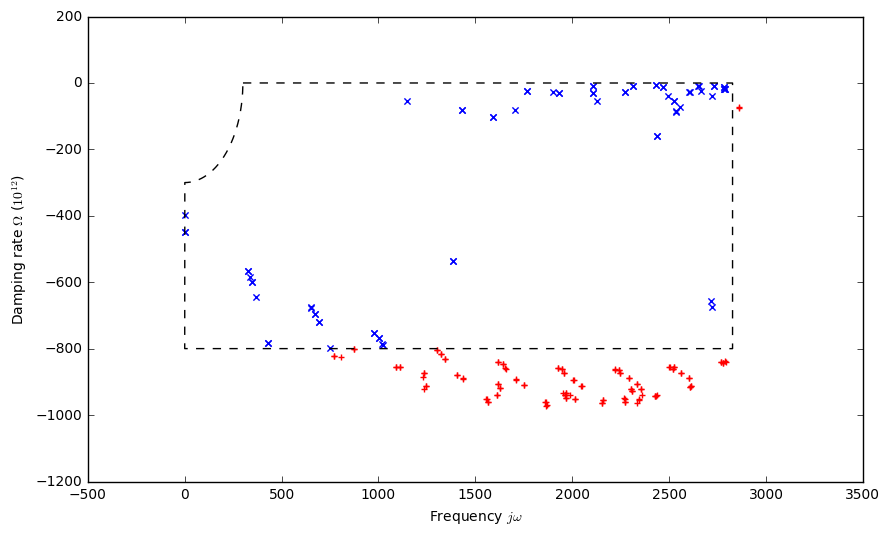

In [9]:
fig = plt.figure(figsize=(10, 6))
points = plt.scatter(estimates.s.imag*1e-12, estimates.s.real*1e-12, marker='x')
plt.scatter(s_out.imag*1e-12, s_out.real*1e-12, marker='+', color='red')
plt.plot(contour_points.imag*1e-12, contour_points.real*1e-12, 'k--')

plt.xlabel('Frequency $j\omega$')
plt.ylabel('Damping rate $\Omega$ ($10^{12}$)')

plt.show()

In [10]:
len(estimates)

74

In [11]:
refined = sim.refine_poles(estimates, max_iter=10)

In [12]:
len(refined)

74

## Show complex frequencies of refined modes

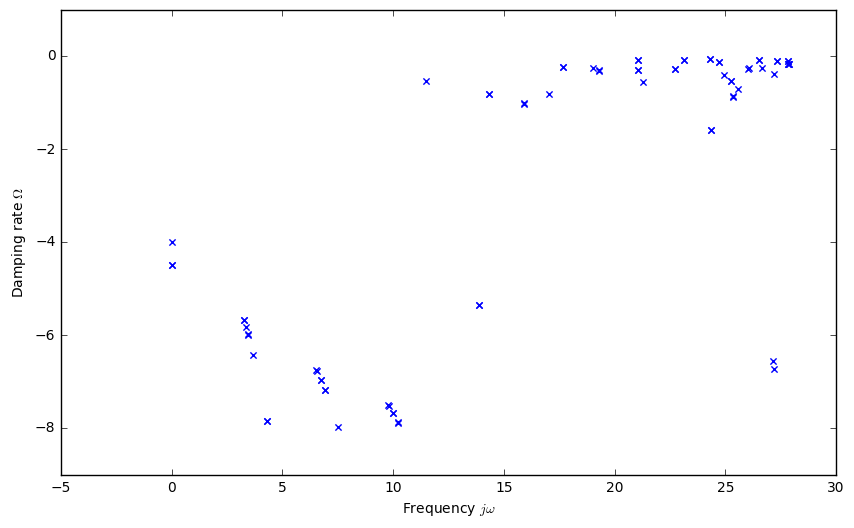

In [13]:
fig = plt.figure(figsize=(10, 6))
points = plt.scatter(refined.s.imag*1e-14, refined.s.real*1e-14, marker='x')

plt.xlabel('Frequency $j\omega$')
plt.ylabel('Damping rate $\Omega$')

plt.show()

## Check the singular value distribution
This gives a visual indication of how well contour integration worked. I have found best results if there is a relatively sharp transition between significant and negligible singular values.

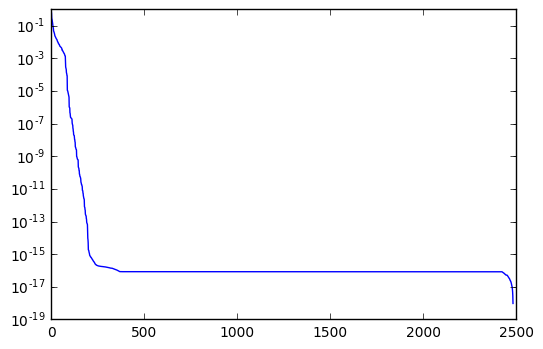

In [14]:
s_vals = estimates.modes_of_parts[sim.parts.unique_id]['C1_S']
plt.figure()
plt.semilogy(s_vals/s_vals[0])
plt.show()

## Plot modes
Plot the current of one of the modes, to see if the solution looks sensible.
Note that in many cases the **imaginary** part of the current solution dominates, but by default the plot shows the real part.

In [15]:
mode = 26
print("Mode at s= ", refined.s['modes', mode])
sim.plot_3d(solution=refined.vr["J", :, 'modes', mode])

Mode at s=  (-5.35992971502e+14+1.38664406333e+15j)


### Define frequency range and incident field

In [16]:
pw = PlaneWaveSource([0, 1, 0], [0, 0, 1], p_inc=1.0)

num_freqs = 200
freqs = np.linspace(100e12, 450e12, num_freqs)

## Calculate extinction by modes

In [17]:
full_modes = refined.add_conjugates()

model = ModelMutualWeight(full_modes)

In [18]:
num_modes = len(model.modes)
extinction_modes = np.empty((num_freqs, num_modes), np.complex128)

vr = model.vr
vl = model.vl

for freq_count, s in sim.iter_freqs(freqs, log_skip=20):
    V = sim.source_vector(pw, s)
    V_E = sim.source_vector(pw, s, extinction_field=True)
    
    I_modes = model.impedance(s).solve(vl.dot(V))
    extinction_modes[freq_count] = V_E.vdot(vr*I_modes)


## Calculate extinction directly
* Also calculate multipole expansion

In [19]:
extinction = np.empty(num_freqs, np.complex128)

num_multipoles = 10
a_e = np.empty((num_freqs, num_multipoles+1, 2*num_multipoles+1), np.complex128)
a_m = np.empty_like(a_e)
k = np.empty(num_freqs)

modal_interference = np.empty((num_freqs, num_modes, num_modes), np.complex128)
extinction_interference = np.empty((num_freqs, num_modes, num_modes), np.complex128)

for freq_count, s in sim.iter_freqs(freqs, log_skip=20):
    Z = sim.impedance(s)
    V = sim.source_vector(pw, s)
    I = Z.solve(V)
    V_E = sim.source_vector(pw, s, extinction_field=True)
    extinction[freq_count] = np.vdot(V_E, I)
    
    k[freq_count] = (s/c/1j).real
    
    a_e[freq_count], a_m[freq_count] = sim.multipole_decomposition(I, num_multipoles, s)
    

## Plot calculated extinction
Comparing extinction from all modes, with direct calculation

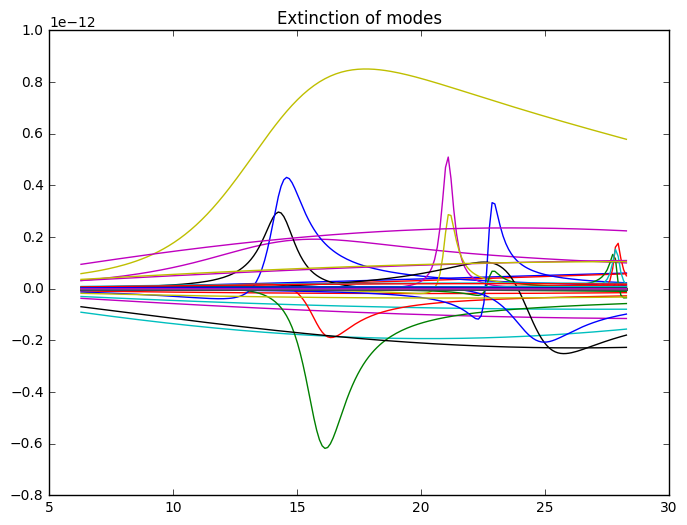

In [20]:
fig = plt.figure(figsize=(8, 6))
lines = plt.plot(freqs*1e-14*2*np.pi, extinction_modes.real)
plt.title('Extinction of modes')
plt.show()

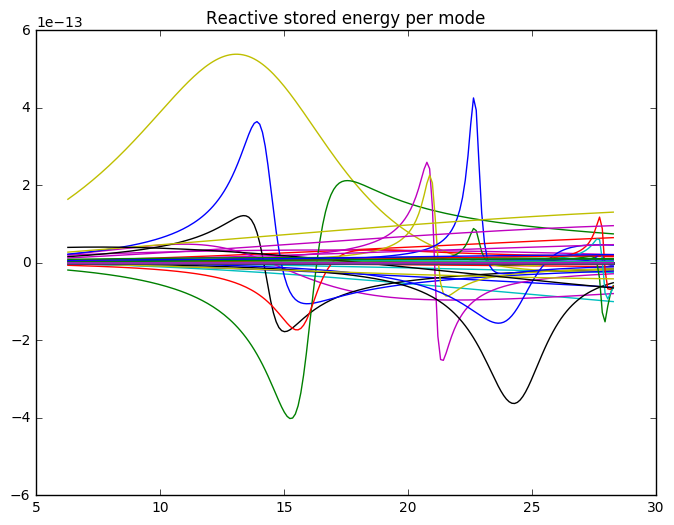

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(freqs*1e-14*2*np.pi, extinction_modes.imag)
plt.title('Reactive stored energy per mode')
plt.show()

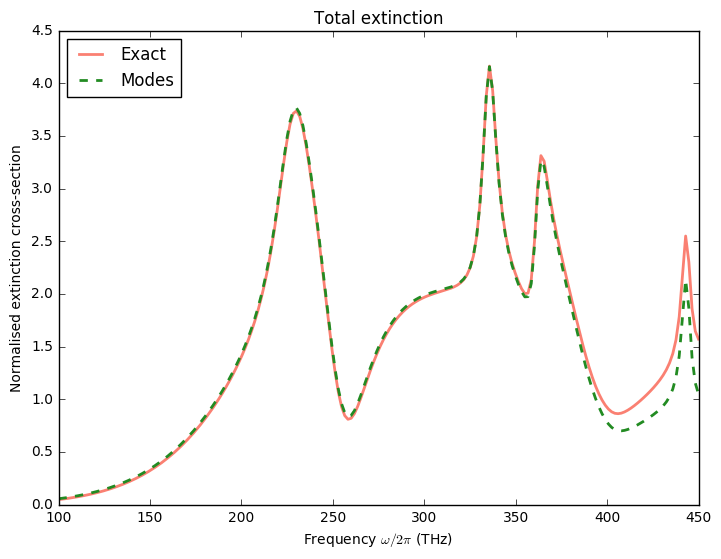

In [22]:

fig = plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.15, right=0.95, top=0.92, bottom=0.13)
#plt.figure(figsize=(8, 6))
plt.plot(freqs*1e-12, extinction.real/cross_section, linewidth=2, color='salmon')
plt.plot(freqs*1e-12, np.sum(extinction_modes.real, axis=1)/cross_section, '--', linewidth=2, color="forestgreen")
plt.legend(("Exact", "Modes"), loc="upper left")
plt.title("Total extinction")
plt.xlabel('Frequency $\omega/2\pi$ (THz)')
plt.ylabel("Normalised extinction cross-section")
plt.show()

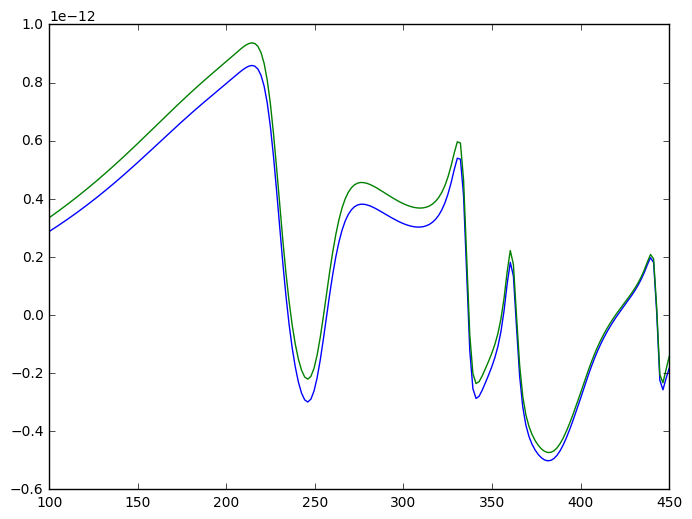

In [23]:
plt.figure(figsize=(8, 6))
plt.plot(freqs*1e-12, extinction.imag)
plt.plot(freqs*1e-12, np.sum(extinction_modes.imag, axis=1))
plt.show()

## Look for degenerate modes
Try to determine which modes are degenerate, and group their extinction together for more convenient plots

In [24]:
def group_modes(modes, threshold=1e-2):
    "Group all modes which are degenerate, and which are complex conjugates of each other, within a certain threshold"

    # determine matching for each unique part id
    matched = {}
    for part_id, part_data in modes.modes_of_parts.items():
        s = part_data['s']
        s = s.real + 1j*np.abs(s.imag) # normalise so that conjugate modes get included
        matched[part_id] = []
        unmatched = list(range(len(s)))

        while len(unmatched) > 0:
            current = unmatched.pop()
            ds = np.abs((s[current]-s[unmatched])/s[current])
            matches = np.where(ds < threshold)[0]
            current_group = [current]
            # Traverse in reverse order so that popping does not invalidate other
            # elements
            for m in reversed(matches):
                current_group.append(unmatched[m])
                unmatched.pop(m)
            matched[part_id].append(current_group)
            
    # turn this into a list of mode numbers
    return matched

In [25]:
matches = list(group_modes(full_modes, 1e-2).values())[0]

extinction_degen = np.zeros((len(freqs), len(matches)), np.complex128)
num_modes = 0
for match_num, match in enumerate(matches):
    for mode in match:
        extinction_degen[:, match_num] += extinction_modes[:, mode]
        num_modes += 1

wanted_degen = np.max(np.abs(extinction_degen), axis=0) > 0.1e-12

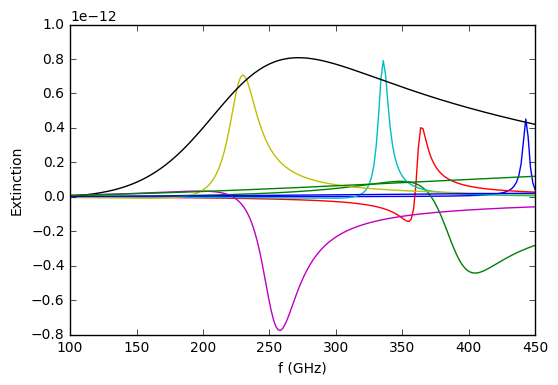

In [26]:
plt.figure()
plt.plot(freqs*1e-12, extinction_degen[:, wanted_degen].real)
plt.xlabel('f (GHz)')
plt.ylabel('Extinction')
plt.show()

## Save results

In [27]:
save_pickle = True

In [28]:
if save_pickle:
    import dill as pickle
    results = {"freqs": freqs, "refined": refined, "parameters": parameters,
               "extinction": extinction, "extinction_modes": extinction_modes, "sim": sim,
                "a_e": a_e, "a_m": a_m, "contour": contour}
    with open("disk_calculations.pickle", "wb") as outfile:
        pickle.dump(results, outfile)